# Data Analysis And Predictions For Coronavirus in Korea
source:-
https://github.com/kevinTheQuigley/DataAnalyticsNCI

# Table of Contents

* [Data Entry](#chapter1)
* [Data Analysis](#DescriptionData)
* [Model Building](#ModelBuilding)
* [Group Analysis](#GroupAnalysis)

In [1]:
#pip install -U seaborn

In [2]:
import kevinDataSetup as ds
from datetime import datetime
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
import scikitplot as skplt
import matplotlib.pyplot as plt

In [3]:
ds.directorySetup()

# Data Entry <a class="anchor" id="chapter1"></a>

Downloading the data as is necessary: 

In [4]:
ds.setupLists()
ds.koreaDataDownload()


Data is present on local machine as CSVs. 

Writing csv to dataframe
Data read from local csv success! 


# Data Analysis <a class="anchor" id= "DescriptionData"></a>

# 1. List Of Tables Present From KDCA
### 1) Case Data
- **Case**: Data of COVID-19 infection cases in South Korea

### 2) Patient Data
- **PatientInfo**: Epidemiological data of COVID-19 patients in South Korea

### 3) Time Series Data
- **Time**: Time series data of COVID-19 status in South Korea
- **TimeAge**: Time series data of COVID-19 status in terms of the age in South Korea
- **TimeGender**: Time series data of COVID-19 status in terms of gender in South Korea
- **TimeProvince**: Time series data of COVID-19 status in terms of the Province in South Korea

### 4) Additional Data
- **Region**: Location and statistical data of the regions in South Korea
- **Weather**: Data of the weather in the regions of South Korea
- **SearchTrend**: Trend data of the keywords searched in NAVER which is one of the largest portals in South Korea
- **SeoulFloating**: Data of floating population in Seoul, South Korea (from SK Telecom Big Data Hub)
- **Policy**: Data of the government policy for COVID-19 in South Korea

# 2. Table Used From Wikipedia
- **GDP per capita per region** The gdp per region in Korea is used to create an interesting numerical predictor for our model

Obtained from the following link:-
https://en.wikipedia.org/wiki/List_of_South_Korean_regions_by_GDP

# Predicting Coronavirus Patient Outcomes

## Data setup for predictive model

In [5]:
# Data before cleaning 
PatientInfo =ds.PatientInfo
Weather=ds.Weather
GDPTable=ds.GDPTable

## Data Exploration

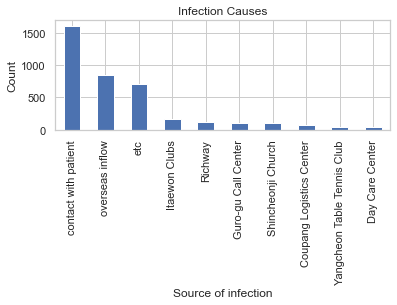

In [6]:
InfectionCount=PatientInfo.infection_case.value_counts()
type(InfectionCount)
#InfectionCount['infection_case']
#InfectionCount.name
InfectionCount.values
#InfectionCount.dtypes
InfectionCount=InfectionCount[(InfectionCount.values>40)]
InfectionCount.plot.bar()
plt.title("Infection Causes")
plt.xlabel("Source of infection")
plt.ylabel("Count")
plt.gcf().subplots_adjust(bottom=0.5)
#plt.tight_layout()
plt.savefig('infectionCauses.png')

The graph shows the various infection cases from which people got infected and their respective frequency. On analyzing the infection case, it can be observed that more number of patients are affected by coming in contact with the other patients followed by overseas inflow

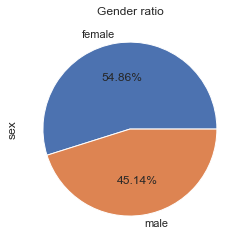

In [7]:
PatientInfo.sex.value_counts().plot.pie(autopct="%0.2f%%")
plt.title("Gender ratio")
plt.savefig('GenderRatio.png')

The plot gives us an understanding of sex ratio of patients. It can be noticed that nearly equal number of men and women are becoming victim of this pandemic. There is however a slight difference. It appears that slightly more men then women are being infected. This could be due to an larger number of women working in face to face roles, like in health care, as teachers or in day care centres. 

Text(0, 0.5, 'Province')

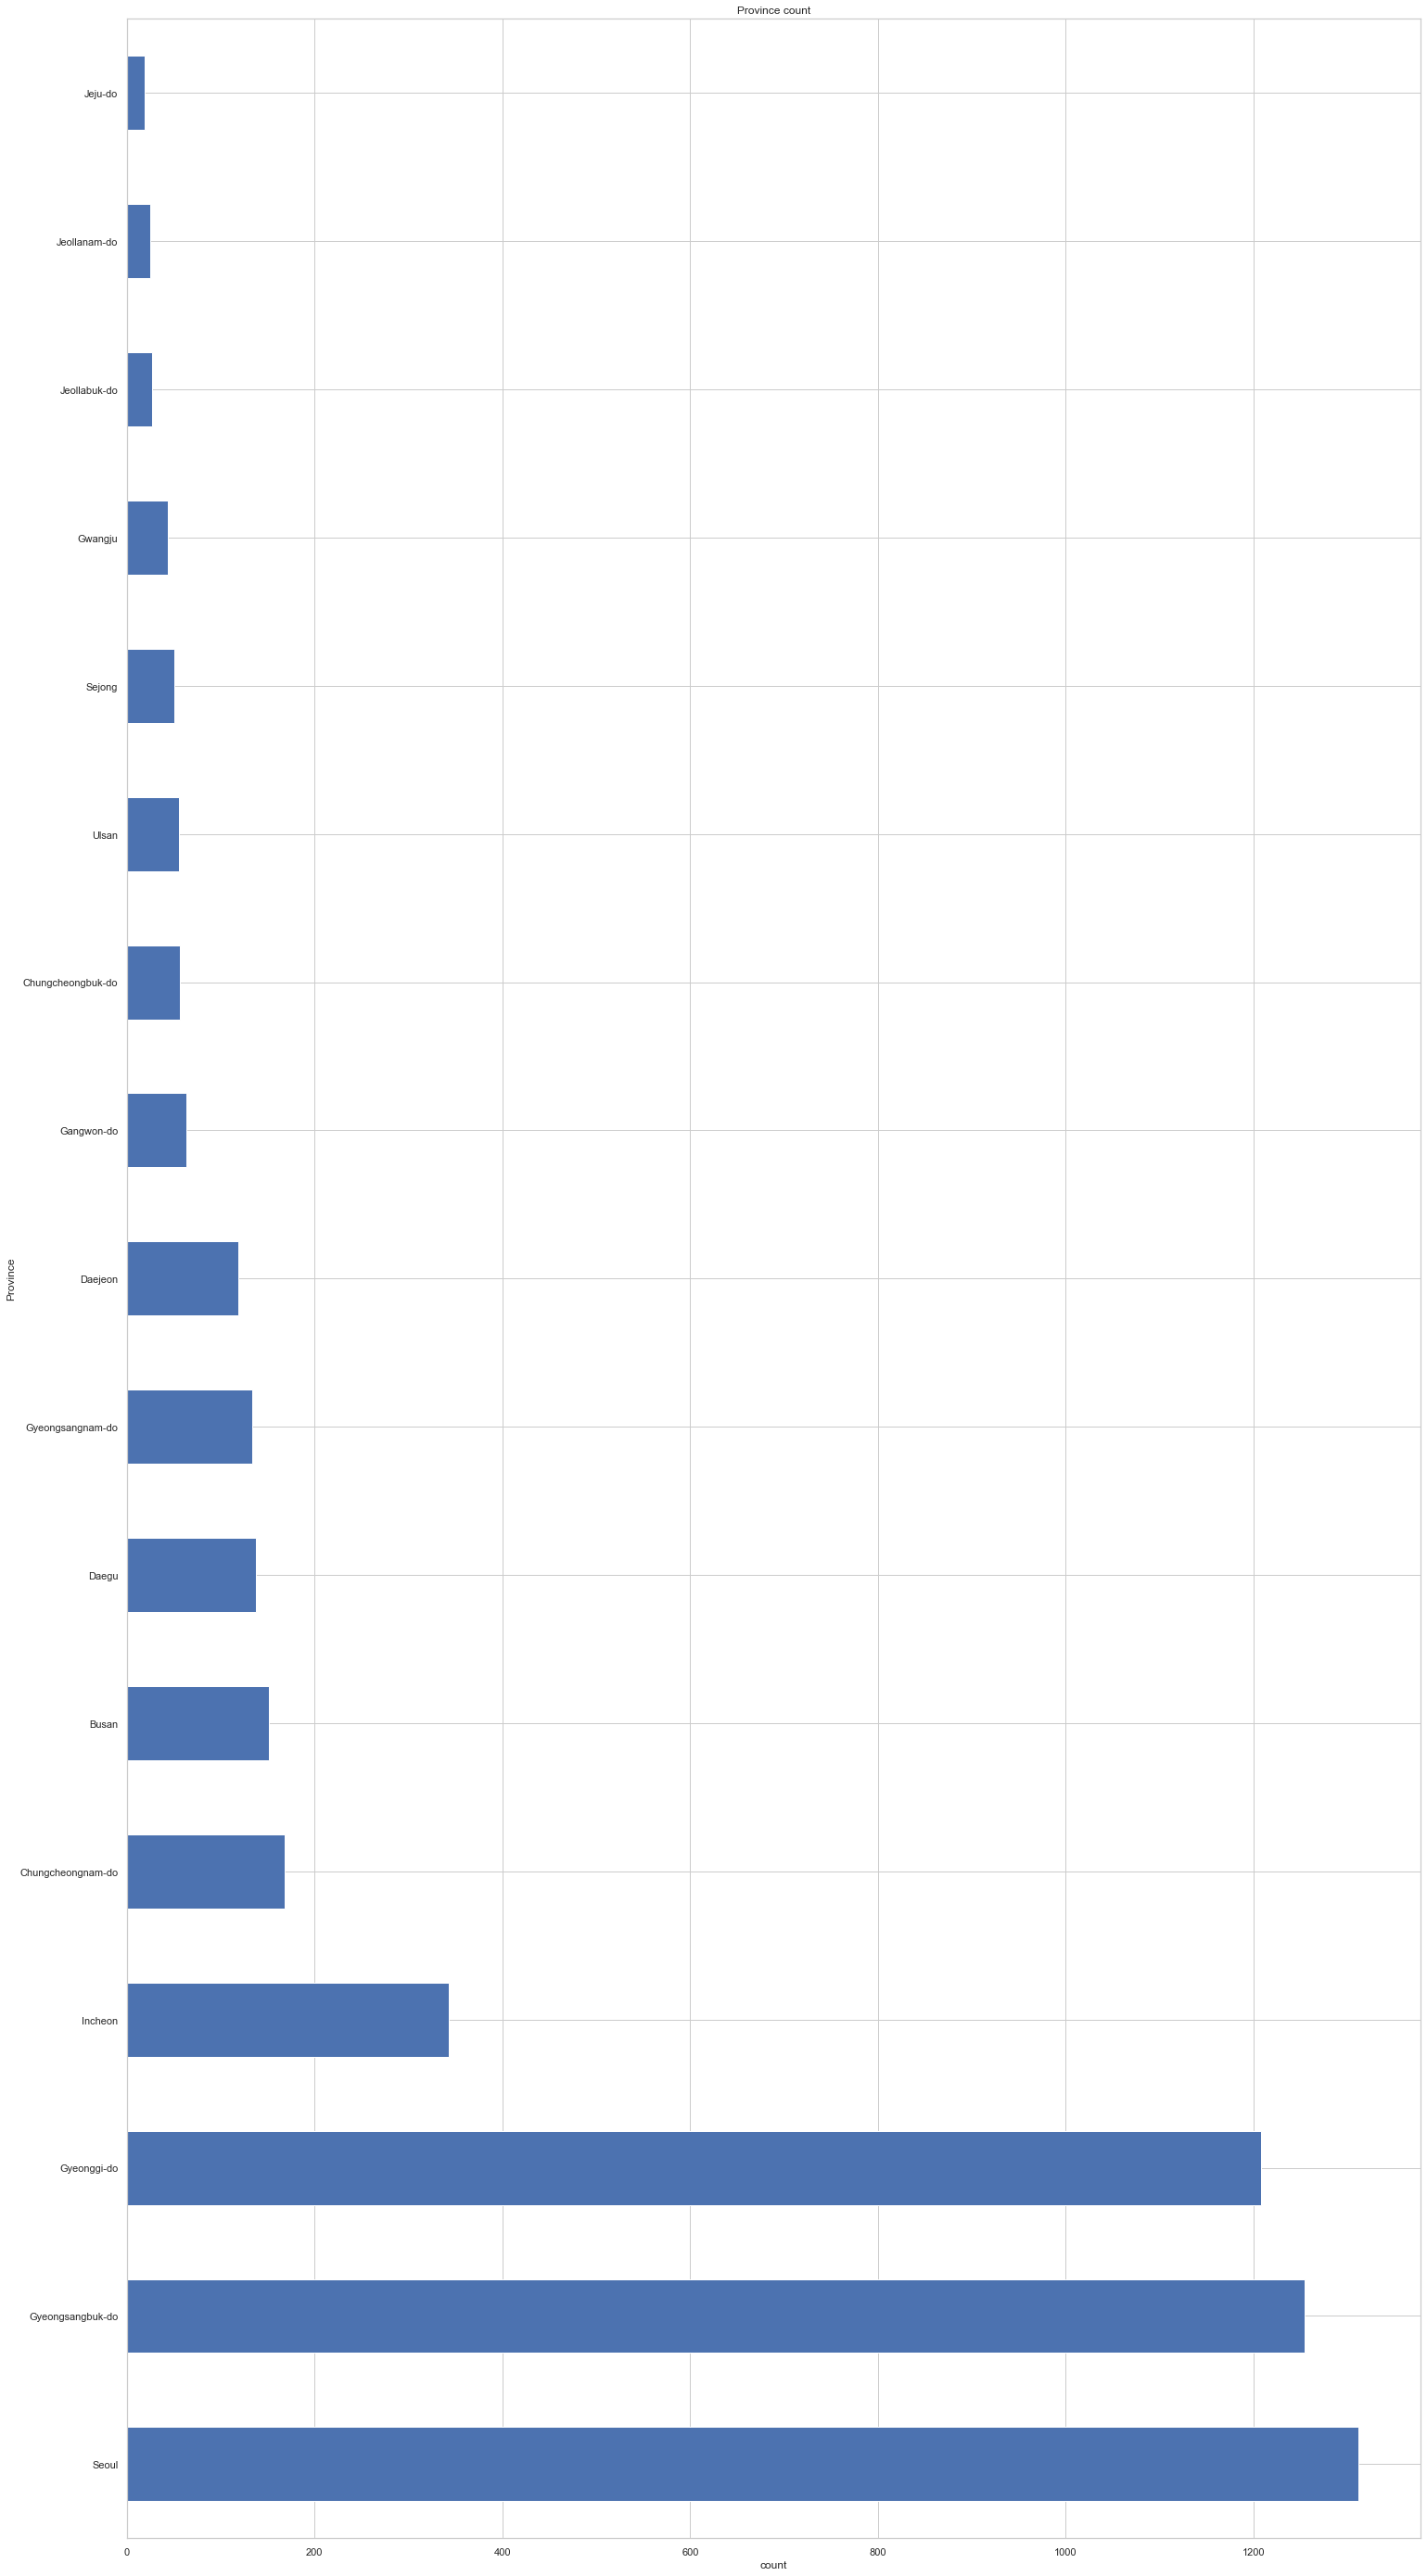

In [8]:
plt.figure(figsize=(25,50))
PatientInfo.province.value_counts().plot(kind='barh')
plt.title("Province count")
plt.xlabel("count")
plt.ylabel("Province")

In [9]:
#PatientInfo.country.drop(labels=['Korea','seanBeen'])

In [10]:
CountryTab=PatientInfo[PatientInfo['country'] != "Korea"]

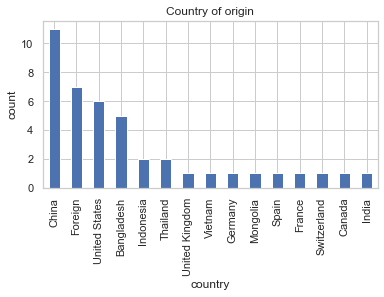

In [11]:
CountryTab.country.value_counts().plot.bar()
plt.title("Country of origin")
plt.xlabel("country")
plt.ylabel("count")
plt.gcf().subplots_adjust(bottom=0.3)
plt.savefig('OriginCountry.png')

## Data Cleaning

In [12]:
## Data Cleaning
PatientInfo['age'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
PatientInfo.age.replace('66s','60s', inplace=True)
PatientInfo['sex'].dropna(axis=0,inplace=True)


# Change to int
d_state =  {"released": 0, 'deceased': 1, 'isolated': 2}
PatientInfo['state'] = PatientInfo['state'].map(d_state)
d_sex = {"male": 1, "female": 0,}
PatientInfo['sex'] = PatientInfo['sex'].map(d_sex)

# fill nan values
PatientInfo['state'].fillna(2, inplace = True)


# Removing open cases
#indexNames = PatientInfo[PatientInfo['state'] == 2].index






## Appending data on GDP per capita figures

Using the GDP table from the data setup file, we can append information on the GDP of each region, and use that as a predictor our model.

In [13]:
ds.unique(PatientInfo['province'])

Seoul
Busan
Daegu
Gwangju
Incheon
Daejeon
Sejong
Gyeonggi-do
Ulsan
Gangwon-do
Chungcheongbuk-do
Chungcheongnam-do
Jeollabuk-do
Jeollanam-do
Gyeongsangbuk-do
Gyeongsangnam-do
Jeju-do


In [14]:
ds.unique(ds.GDPTable["Region"])

Gyeongbuk
Sejong
Incheon
Gwangju
National Average
Gyeongnam
Busan
Seoul
Jeju
Chungnam
Jeonbuk
Gangwon
Chungbuk
Gyeonggi
Ulsan
Daejeon
Jeonnam
Daegu


In [15]:
GDPSorted = ds.GDPTable.rename(columns = {'GDP per capita(million KRW)[6]': 'gdp', 'Region': 'province'}, inplace = False)
GDPSorted['province'].replace({'Chungnam': 'Chungcheongnam-do', 'Chungbug': 'Chungcheongbuk-do', 'Jeonnam': 'Jeollanam-do',
                               'Gyeongbuk': 'Gyeongsangbuk-do','Gyeonggi': 'Gyeonggi-do','Gyeongnam': '-Gyeongsangnam-do',
                               'Gangwon': 'Gangwon-do','Jeju': 'Jeju-do','Jeonbuk': 'Jeollabuk-do'}, inplace = True)

In [16]:
PatientInfo=pd.merge(PatientInfo, GDPSorted[['province','gdp']], on='province',how='left')

In [17]:
PatientInfo['gdp']

0       43.53
1       43.53
2       43.53
3       43.53
4       43.53
        ...  
5160      NaN
5161      NaN
5162    30.51
5163    30.51
5164    30.51
Name: gdp, Length: 5165, dtype: float64

In [18]:
PatientInfo["confirmed_date"]


0       2020-01-31
1       2020-02-16
2       2020-02-22
3       2020-02-20
4       2020-02-22
           ...    
5160    2020-03-26
5161    2020-03-31
5162    2020-03-02
5163    2020-04-03
5164    2020-06-18
Name: confirmed_date, Length: 5165, dtype: object

In [19]:
Weather.dtypes

code                       int64
province                  object
date                      object
avg_temp                 float64
min_temp                 float64
max_temp                 float64
precipitation            float64
max_wind_speed           float64
most_wind_direction      float64
avg_relative_humidity    float64
dtype: object

In [20]:
Weather['date'] =  pd.to_datetime(Weather['date'], format='%Y-%m-%d')
Weather['date'] =  Weather['date'] + pd.offsets.DateOffset(years=4)

In [21]:
PatientInfo['date'] =  pd.to_datetime(PatientInfo['confirmed_date'], format='%Y-%m-%d')

In [22]:
Weather['date']=Weather['date']  + pd.offsets.MonthBegin(0)
PatientInfo['date']=PatientInfo['date'] + pd.offsets.MonthBegin(0)
PatientInfo['date'].dropna(axis=0,inplace=True)

In [23]:
len(PatientInfo)

5165

In [24]:
Weather['dayW'] = Weather['date'].dt.strftime('%m-%d-%Y')

In [25]:
PatientInfo['dayP'] = PatientInfo['date'].dt.strftime('%m-%d-%Y')

## Appending the weather figures

In [26]:
tmp = Weather.groupby(['province', 'dayW']).min_temp.transform(max)
Weather = Weather.loc[Weather.min_temp == tmp]

In [27]:
PatientInfo = PatientInfo.merge(Weather, how='inner', left_on=["province", "dayP"], right_on=["province","dayW"])

In [28]:
PatientInfo.dtypes

patient_id                        int64
sex                             float64
age                              object
country                          object
province                         object
city                             object
infection_case                   object
infected_by                      object
contact_number                   object
symptom_onset_date               object
confirmed_date                   object
released_date                    object
deceased_date                    object
state                             int64
gdp                             float64
date_x                   datetime64[ns]
dayP                             object
code                              int64
date_y                   datetime64[ns]
avg_temp                        float64
min_temp                        float64
max_temp                        float64
precipitation                   float64
max_wind_speed                  float64
most_wind_direction             float64


In [29]:
PatientInfo = PatientInfo.reset_index(drop=False)

In [30]:
indexNames = PatientInfo[PatientInfo['state'] == 2].index
PatientInfo_Closed = PatientInfo.drop(indexNames)

# Closed cases post cleaning 
PatientInfo_Closed.head()

index  patient_id  sex age country province         city  \
0      0  1000000006  0.0  50   Korea    Seoul    Jongno-gu   
1      1  1000000001  1.0  50   Korea    Seoul   Gangseo-gu   
2      2  1000000004  1.0  20   Korea    Seoul      Mapo-gu   
3      3  1000000002  1.0  30   Korea    Seoul  Jungnang-gu   
4      4  1000000007  1.0  20   Korea    Seoul    Jongno-gu   

         infection_case infected_by contact_number  ...   code     date_y  \
0  contact with patient  1000000003             43  ...  10000 2020-02-01   
1       overseas inflow         NaN             75  ...  10000 2020-02-01   
2       overseas inflow         NaN              9  ...  10000 2020-02-01   
3       overseas inflow         NaN             31  ...  10000 2020-02-01   
4  contact with patient  1000000003              0  ...  10000 2020-02-01   

  avg_temp min_temp  max_temp  precipitation max_wind_speed  \
0      6.5      5.1       9.4            0.0            4.0   
1      6.5      5.1       9.4            0.0            4.0   
2      6.5      5.1       9.4            0.0            4.0   
3      6.5      5.1       9.4            0.0            4.0   
4      6.5      5.1       9.4            0.0            4.0   

  most_wind_direction  avg_relative_humidity        dayW  
0               320.0                   80.6  02-01-2020  
1               320.0                   80.6  02-01-2020  
2               320.0                   80.6  02-01-2020  
3               320.0                   80.6  02-01-2020  
4               320.0                   80.6  02-01-2020  

[5 rows x 28 columns]

Seoul-Seoul
Chungnam-Chungcheongnam-do
Chungbug-Chungcheongbuk-do
Ulsan-Ulsan
Jeonnam-Jeollanam-do
Gyeongbuk-Gyeongsangbuk-do
Sejong-Sejong
Gyeonggi- Gyeonggi-do
Gyeongnam-Gyeongsangnam-do
Gangwon-Gangwon-do
Jeju-Jeju-do
Incheon-Incheon
Jeonbuk-Jeollabuk-do
Daejeon-Daejeon
Gwangju-Gwanju
Busan-Busan
Daegu-Daegu


## Visualisations 

In [31]:
age_dist = PatientInfo_Closed['age'].value_counts()
px.bar(age_dist, title='Age distribution')

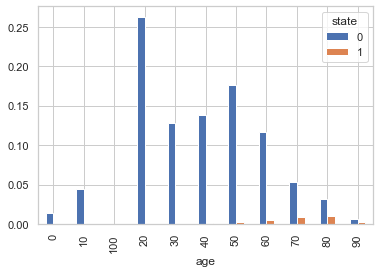

In [32]:
death_by_age = pd.crosstab(PatientInfo_Closed ['age'], PatientInfo_Closed ['state'], normalize=True).plot(kind='bar')
#px.bar(death_by_age, title='Death by age')
plt.savefig("deathByAge")

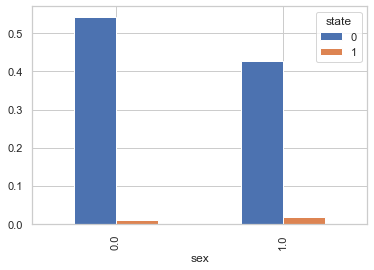

In [33]:
death_by_sex = pd.crosstab(PatientInfo_Closed ['sex'], PatientInfo_Closed ['state'], normalize=True).plot(kind='bar')

In [34]:
gdp_dist = PatientInfo_Closed['gdp'].value_counts()
px.bar(gdp_dist, title='gdp distribution')

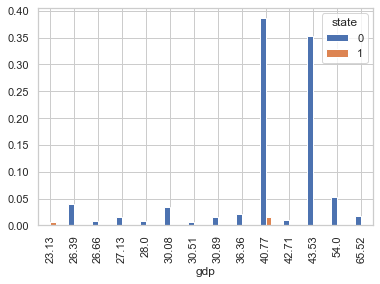

In [35]:
death_by_gdp = pd.crosstab(PatientInfo_Closed ['gdp'], PatientInfo_Closed ['state'], normalize=True).plot(kind='bar')

In [36]:
PatientInfo['contact_number']

0        43
1        75
2         9
3        31
4         0
       ... 
5120    NaN
5121    NaN
5122    NaN
5123     84
5124     87
Name: contact_number, Length: 5125, dtype: object

PatientInfo.groupby('sex')['contact_number'].mean().plot.bar()
plt.ylabel("Contact numbers mean")
plt.title("Male vs Female wrt Contact number")

## Creating the closed case dataset

In [37]:
PatientInfo_Closed ['state']

0       0
1       0
2       0
3       0
4       0
       ..
5117    0
5118    0
5120    0
5123    0
5124    0
Name: state, Length: 2967, dtype: int64

In [38]:
PI_C = PatientInfo_Closed[['state', 'age', 'sex','gdp','avg_temp']]


In [39]:
PI_C.dtypes

state         int64
age          object
sex         float64
gdp         float64
avg_temp    float64
dtype: object

In [40]:
# Save only informative features and change datatypes
PI_C = PatientInfo_Closed[['state', 'age', 'sex','gdp','avg_temp']]
PI_C['age'].dropna(axis=0,inplace=True)
PI_C.dtypes
PI_C["age"] = pd.to_numeric(PI_C["age"])
PI_C.dtypes
PI_C.fillna(0,inplace = True)
PI_C.dropna(inplace=True)

<ipython-input-40-b210110d7024>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-40-b210110d7024>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\kevin\AppData\Local\Programs\Python\Python38-32\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-40-b210110d7024>:8: SettingWithCopyWarning:


A value is 

## Stratifying Split Data

In [41]:
y = PI_C['state']
X = PI_C.drop('state', axis = 1)

X_train, X_test, y_train, y_test,  = train_test_split(X, y, test_size=0.3,random_state=10, stratify=y)

In [42]:
y_train.dtypes

dtype('int64')

In [43]:
sum(y_train)
y_train

4455    0
4161    0
4371    0
777     0
3389    0
       ..
1631    0
727     0
181     0
1192    0
4850    0
Name: state, Length: 2076, dtype: int64

In [44]:
min(y)

0

# Building the model <a class="anchor" id= "ModelBuilding"></a>

In [45]:
model = LogisticRegression(solver='liblinear', random_state=0,class_weight = 'balanced').fit(X_train, y_train)
y_pred=model.predict(X_test)

In [46]:
print(model.intercept_)
print(model.coef_)

[-6.69080611]
[[ 0.08267552  0.9104116  -0.01297901  0.17599679]]


In [47]:
model.score(X_test, y_test)


0.8260381593714927

In [48]:
confusion_matrix(y_test, y_pred)

array([[718, 150],
       [  5,  18]], dtype=int64)

Our model predicts that of the 237 people who are predicted to die, only 22 will actually die. Better safe then sorry! Still there may be a way to further improve the model.


In [49]:
sum(y_pred)

168

In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.83      0.90       868
           1       0.11      0.78      0.19        23

    accuracy                           0.83       891
   macro avg       0.55      0.80      0.55       891
weighted avg       0.97      0.83      0.88       891



Confusion matrix, without normalization
[[718 150]
 [  5  18]]


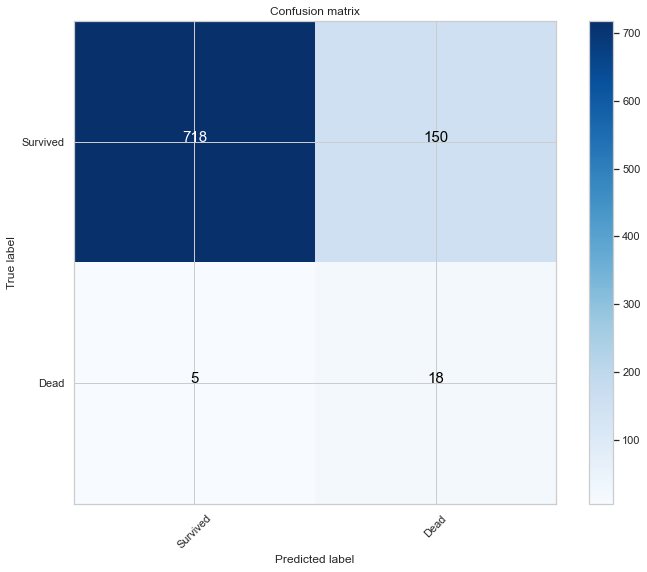

In [51]:
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, model.predict(X_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Survived', 'Dead'],
                      title='Confusion matrix', normalize=False)
plt.savefig("conf_matrix1.png")
plt.show()

 Unfortunately our inital model only predicts that people won't die from the coronavirus! We need to change the weighting to improve the results.
 
Adding the weight class=balanced seems to work pretty well

In [52]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.099061
         Iterations 10
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.190     
Dependent Variable: state            AIC:              419.3030  
Date:               2021-05-08 15:44 BIC:              441.8558  
No. Observations:   2076             Log-Likelihood:   -205.65   
Df Model:           3                LL-Null:          -253.96   
Df Residuals:       2072             LLR p-value:      8.2739e-21
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     10.0000                                      
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
age           0.0681    0.0083    8.1919  0.0000   0.0518   0.0843
sex           0.5107    0.2704    1.8885  0.0590  -0.0193   1

In [53]:
logit_model.fit().params

Optimization terminated successfully.
         Current function value: 0.099061
         Iterations 10


age         0.068056
sex         0.510653
gdp        -0.060524
avg_temp   -0.419354
dtype: float64

In [54]:
coef=abs(logit_model.fit().params)
px.bar(coef, title='Coefficient Weighting')


Optimization terminated successfully.
         Current function value: 0.099061
         Iterations 10


In [55]:
plot=px.bar(coef, title='Coefficient Weighting')
#plt.savefig("CoefficientBarPlot.png")
plot.write_image("CoefficientBarPlot.png")

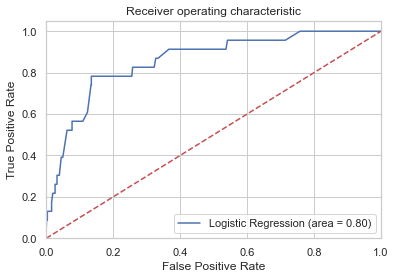

In [56]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
logreg = LogisticRegression()

logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
#plt.show()

How to choose the best point from an ROC curve 

Confusion matrix, without normalization
[[718 150]
 [  5  18]]


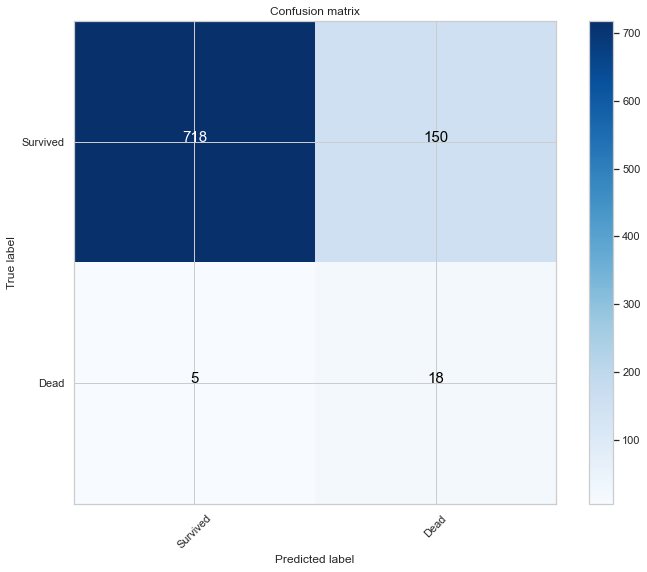

In [57]:
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, model.predict(X_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Survived', 'Dead'],
                      title='Confusion matrix', normalize=False)
plt.savefig("conf_matrix.png")
plt.show()

Choosing more appropriate weights

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\kevin\AppData\Local\Programs\Python\Python38-32\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



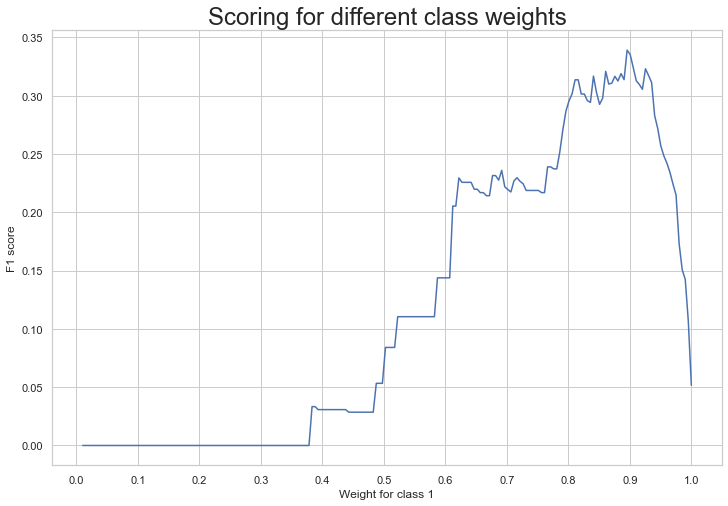

In [58]:
from sklearn.model_selection import  StratifiedKFold
lr = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)
plt.savefig("WeightScoring.png")

The f1 score for the testing data: 0.20809248554913296
Confusion matrix, without normalization
[[736 132]
 [  5  18]]


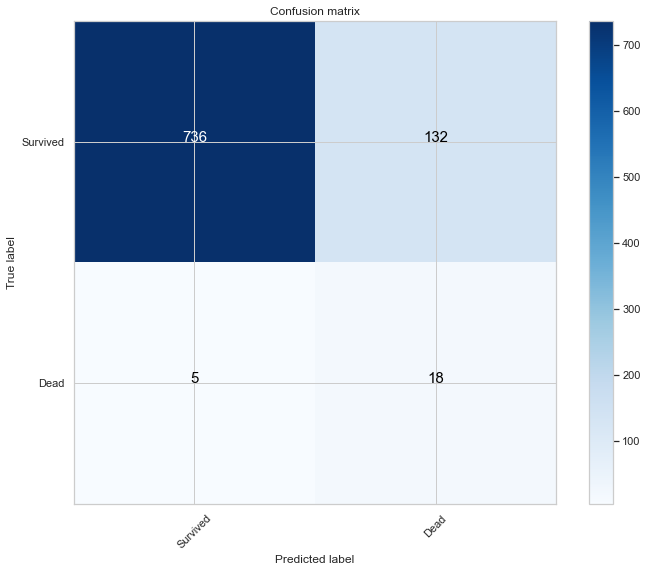

In [59]:
#importing and training the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
lr = LogisticRegression(solver='newton-cg', class_weight={0: 0.035, 1: 0.965})
lr.fit(X_train, y_train)

# Predicting on the test data
pred_test = lr.predict(X_test)

#Calculating and printing the f1 score 
f1_test = f1_score(y_test, pred_test)
print('The f1 score for the testing data:', f1_test)

#Ploting the confusion matrix
#conf_matrix(y_test, pred_test)


cnf_matrix = confusion_matrix(y_test, pred_test)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Survived', 'Dead'],
                      title='Confusion matrix', normalize=False)
plt.savefig("conf_matrix2.png")
plt.show()

In [60]:
lr.fit(X_train, y_train)
coef=abs(logit_model.fit().params)
px.bar(coef, title='Coefficient Weighting')

Optimization terminated successfully.
         Current function value: 0.099061
         Iterations 10


In [61]:
len(y_test)

891

In [62]:
# Finding the accuracy
Accuracy = round(1-abs((sum(y_test-pred_test))/len(y_test)),2)
print("The accuracy of our model is {} percent ".format(Accuracy))

The accuracy of our model is 0.86 percent 


In [63]:
data_final_vars=PI_C
y=['y']
X=[i for i in data_final_vars if i not in y]

logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_train, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True]
[1 1 1 1]


C:\Users\kevin\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning:

Pass n_features_to_select=20 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error



# Group Analysis <a class="anchor" id="GroupAnalysis"></a>

Next we bring in air traffic from the first 9 mounths of 2020 to compare with our dataset. For this analysis, we use our fourth table, the time table, which contains the pre-aggregated sums of the numbers of deaths and confirmed cases of covid for Korea for the first 6 months of 2020

In [278]:
KorTime

date  time     test  negative  confirmed  released  deceased  \
0   2020-01-29    16      187       155          4         0         0   
1   2020-02-08    16     2097      1134         24         2         0   
2   2020-01-31    16      312       245         11         0         0   
3   2020-02-06    16      885       693         23         2         0   
4   2020-02-16    16     8161      7647         29         9         0   
..         ...   ...      ...       ...        ...       ...       ...   
158 2020-05-14     0   711484    679771      10991      9762       260   
159 2020-05-19     0   765574    737571      11078      9938       263   
160 2020-05-22     0   802418    770990      11142     10162       264   
161 2020-06-24     0  1208597   1175817      12535     10930       281   
162 2020-06-11     0  1066888   1029447      11947     10654       276   

    month_year  
0      2020-01  
1      2020-02  
2      2020-01  
3      2020-02  
4      2020-02  
..         ...  
158    2020-05  
159    2020-05  
160    2020-05  
161    2020-06  
162    2020-06  

[163 rows x 8 columns]

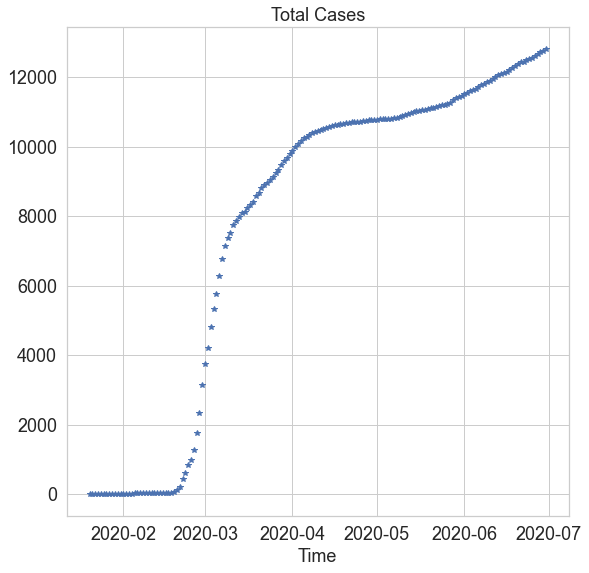

In [299]:
plt.figure(figsize=(9, 9))
plt.plot(KorTime["date"],KorTime["confirmed"],"*")
plt.title("Total Cases")
plt.xlabel("Time")
plt.savefig('CasesTime.png')


In [272]:
KorTime=ds.Time
KorTime['date'] = pd.to_datetime(KorTime['date'])
grouper = pd.Grouper(key='date', freq='M')
KorMonth = KorTime.groupby(grouper)['confirmed'].sum().reset_index()
KorMonth['month_year']=pd.to_datetime(KorMonth['date']).dt.to_period('M')
KorMonth['month_year'] = KorMonth['month_year'].dt.strftime('%Y-%m')

Here we download Colums central data set for 2020 

In [164]:
Air=ds.MongoToDataFrame(ds.client,"airTrafficData","AirTrafficDataFirst9Months2020",True)

Connecting to Mongo Database


In [132]:
Air = Air.iloc[:-1 , :]

In [182]:
Air['month_year']=Air['date'].astype(str)

In [166]:
PatientInfo['month_year'] = pd.to_datetime(PatientInfo['dayW']).dt.to_period('M')

In [126]:
PatientInfo['month_year'] = PatientInfo['month_year'].dt.strftime('%Y-%m')

In [175]:
KorMonth['month_year'] = pd.to_datetime(KorMonth['date']).dt.to_period('M')

In [177]:
KorMonth['month_year']=KorMonth['month_year'].dt.strftime('%Y-%m')

In [186]:
KoreaAirMerged=pd.merge(KorMonth, Air, on='month_year')

In [194]:
ds.write_df_to_mongoDB(KoreaAirMerged,"JoinedDataSets","KoreaAirMerged",ds.client,100)

100
200
300
400
500
600
700
800
900
948
Data upload to Mongo DB Complete


In [213]:
KoreaAirMerged

date_x  confirmed month_year         country    transport_cov  \
0   2020-01-31         40    2020-01         Austria             INTL   
1   2020-01-31         40    2020-01         Austria  INTL_IEU27_2020   
2   2020-01-31         40    2020-01         Austria  INTL_XEU27_2020   
3   2020-01-31         40    2020-01         Austria            TOTAL   
4   2020-01-31         40    2020-01         Belgium             INTL   
..         ...        ...        ...             ...              ...   
943 2020-06-30     364458    2020-06  United Kingdom  INTL_IEU27_2020   
944 2020-06-30     364458    2020-06  United Kingdom  INTL_XEU27_2020   
945 2020-06-30     364458    2020-06  United Kingdom              NAT   
946 2020-06-30     364458    2020-06  United Kingdom            TOTAL   
947 2020-06-30     364458    2020-06      Martinique             INTL   

      date_y  passengers  passenger_flights  freight_mail_on_board  \
0    2020-01   2342644.0            20828.0                21498.0   
1    2020-01   1382784.0            13305.0                 7008.0   
2    2020-01    870144.0             6859.0                14489.0   
3    2020-01   2393427.0            21884.0                21498.0   
4    2020-01   1780025.0            15833.0               109323.0   
..       ...         ...                ...                    ...   
943  2020-06    323861.0             3992.0                39077.0   
944  2020-06    236656.0             2621.0               114122.0   
945  2020-06    111785.0             5916.0                13666.0   
946  2020-06    678083.0            12718.0               166964.0   
947  2020-06         NaN                NaN                    4.0   

     freight_mail_flights  seats_available  all_commercial_flights  
0                   444.0          3360664                   21579  
1                   283.0          2048562                   13874  
2                   161.0          1194691                    7041  
3                   444.0          3446749                   22636  
4                  3725.0          2573255                   19558  
..                    ...              ...                     ...  
943                2139.0           716011                    6176  
944                3750.0          1481130                    6396  
945                1764.0           319056                    7961  
946                7681.0          2534968                   20691  
947                   NaN             2160                       9  

[948 rows x 12 columns]

In [215]:
grouper = pd.Grouper(key='date', freq='M')
KorMonth2 = KorTime.groupby(grouper)['deceased'].sum().reset_index()

In [216]:
KorMonth2

date  deceased
0 2020-01-31         0
1 2020-02-29        86
2 2020-03-31      2590
3 2020-04-30      6525
4 2020-05-31      8081
5 2020-06-30      8326

In [219]:
KorMonth2['month_year']=pd.to_datetime(KorMonth2['date']).dt.to_period('M')

In [220]:
KorMonth2['month_year']=KorMonth2['month_year'].dt.strftime('%Y-%m')

In [221]:
KoreaAirMergedDeceased=pd.merge(KorMonth2, Air, on='month_year')

In [222]:
ds.write_df_to_mongoDB(KoreaAirMerged,"JoinedDataSets","KoreaAirMergedDeceased",ds.client,100)

100
200
300
400
500
600
700
800
900
948
Data upload to Mongo DB Complete


In [239]:
KoreaAirMerged

date_x  deceased month_year         country    transport_cov date_y  \
0   2020-01-31         0        Jan         Austria             INTL    Jan   
1   2020-01-31         0        Jan         Austria  INTL_IEU27_2020    Jan   
2   2020-01-31         0        Jan         Austria  INTL_XEU27_2020    Jan   
3   2020-01-31         0        Jan         Austria            TOTAL    Jan   
4   2020-01-31         0        Jan         Belgium             INTL    Jan   
..         ...       ...        ...             ...              ...    ...   
943 2020-06-30      8326       June  United Kingdom  INTL_IEU27_2020   June   
944 2020-06-30      8326       June  United Kingdom  INTL_XEU27_2020   June   
945 2020-06-30      8326       June  United Kingdom              NAT   June   
946 2020-06-30      8326       June  United Kingdom            TOTAL   June   
947 2020-06-30      8326       June      Martinique             INTL   June   

     passengers  passenger_flights  freight_mail_on_board  \
0     2342644.0            20828.0                21498.0   
1     1382784.0            13305.0                 7008.0   
2      870144.0             6859.0                14489.0   
3     2393427.0            21884.0                21498.0   
4     1780025.0            15833.0               109323.0   
..          ...                ...                    ...   
943    323861.0             3992.0                39077.0   
944    236656.0             2621.0               114122.0   
945    111785.0             5916.0                13666.0   
946    678083.0            12718.0               166964.0   
947         NaN                NaN                    4.0   

     freight_mail_flights  seats_available  all_commercial_flights  
0                   444.0          3360664                   21579  
1                   283.0          2048562                   13874  
2                   161.0          1194691                    7041  
3                   444.0          3446749                   22636  
4                  3725.0          2573255                   19558  
..                    ...              ...                     ...  
943                2139.0           716011                    6176  
944                3750.0          1481130                    6396  
945                1764.0           319056                    7961  
946                7681.0          2534968                   20691  
947                   NaN             2160                       9  

[948 rows x 12 columns]

In [243]:
AirTrafficSummaryStats['Month']

0    0
1    1
2    2
3    3
4    4
5    5
6    6
7    7
8    8
Name: Month, dtype: int64

In [256]:
AirTrafficSummaryStats=ds.MongoToDataFrame(ds.client,'JoinedDataSets','AirTrafficSummaryStats', False)
AirTrafficSummaryStats['Month']=AirTrafficSummaryStats.index



Connecting to Mongo Database


In [257]:
AirTrafficSummaryStats=AirTrafficSummaryStats.replace(1,'Jan')
AirTrafficSummaryStats=AirTrafficSummaryStats.replace(2,'Feb')
AirTrafficSummaryStats=AirTrafficSummaryStats.replace(3,'Mar')
AirTrafficSummaryStats=AirTrafficSummaryStats.replace(4,'April')
AirTrafficSummaryStats=AirTrafficSummaryStats.replace(5,'May')
AirTrafficSummaryStats=AirTrafficSummaryStats.replace(6,'June')
AirTrafficSummaryStats=AirTrafficSummaryStats.replace(7,'July')
AirTrafficSummaryStats=AirTrafficSummaryStats.replace(8,'Aug')
AirTrafficSummaryStats=AirTrafficSummaryStats.replace(9,'Sep')

In [269]:

PartialKorea=KoreaAirMerged[['deceased','month_year']]
mergeddf=pd.merge(AirTrafficSummaryStats,PartialKorea,left_on='Month',right_on='month_year')
mergeddf=mergeddf.drop_duplicates()
mergeddf=mergeddf.set_index('Month')
mergeddf=mergeddf.rename(columns={"deceased": "deceased"})
del mergeddf['month_year']
mergeddf


_id  PassengersonBoard  FreightMailOnBoard  \
Month                                                                    
Jan    6097090ecd9034497e29f1d2         101.252144          102.186996   
Feb    6097090ecd9034497e29f1d3          37.914732           85.706980   
Mar    6097090ecd9034497e29f1d4           1.009433           69.812537   
April  6097090ecd9034497e29f1d5           1.755584           80.164515   
May    6097090ecd9034497e29f1d6           5.500157           90.252481   
June   6097090ecd9034497e29f1d7          21.785751           83.104483   

       SeatsAvailable  CommPassengerFlights  CommFREIGHTMAILFlights  \
Month                                                                 
Jan        101.743250             99.999114              105.174204   
Feb         54.069618             54.226029              106.663629   
Mar          3.735960              4.728297              122.749938   
April        4.426299              5.214748              142.260336   
May          9.097176             10.824286              151.880855   
June        30.607984             36.041547              141.270144   

       AllCommercialFlights  deceased  
Month                                  
Jan              100.476240         0  
Feb               57.691551        86  
Mar                9.595461      2590  
April             10.083791      6525  
May               15.488269      8081  
June              39.316040      8326

In [268]:
KoreaAirMerged=KoreaAirMergedDeceased
KoreaAirMerged=KoreaAirMerged.replace('2020-01','Jan')
KoreaAirMerged=KoreaAirMerged.replace('2020-02','Feb')
KoreaAirMerged=KoreaAirMerged.replace('2020-03','Mar')
KoreaAirMerged=KoreaAirMerged.replace('2020-04','April')
KoreaAirMerged=KoreaAirMerged.replace('2020-05','May')
KoreaAirMerged=KoreaAirMerged.replace('2020-06','June')
KoreaAirMerged=KoreaAirMerged.replace('2020-07','July')
KoreaAirMerged=KoreaAirMerged.replace('2020-08','Aug')
KoreaAirMerged=KoreaAirMerged.replace('2020-09','Sep')

AirTrafficSummaryStats['Month']=AirTrafficSummaryStats.index
PartialKorea=KoreaAirMerged[['confirmed','month_year']]
mergeddf=pd.merge(AirTrafficSummaryStats,PartialKorea,left_on='Month',right_on='month_year')
mergeddf=mergeddf.drop_duplicates()
mergeddf=mergeddf.set_index('Month')
mergeddf=mergeddf.rename(columns={"confirmed": "ConfirmedCases"})
del mergeddf['month_year']
mergeddf

_id  PassengersonBoard  FreightMailOnBoard  \
Month                                                                    
Jan    6097090ecd9034497e29f1d2         101.252144          102.186996   
Feb    6097090ecd9034497e29f1d3          37.914732           85.706980   
Mar    6097090ecd9034497e29f1d4           1.009433           69.812537   
April  6097090ecd9034497e29f1d5           1.755584           80.164515   
May    6097090ecd9034497e29f1d6           5.500157           90.252481   
June   6097090ecd9034497e29f1d7          21.785751           83.104483   

       SeatsAvailable  CommPassengerFlights  CommFREIGHTMAILFlights  \
Month                                                                 
Jan        101.743250             99.999114              105.174204   
Feb         54.069618             54.226029              106.663629   
Mar          3.735960              4.728297              122.749938   
April        4.426299              5.214748              142.260336   
May          9.097176             10.824286              151.880855   
June        30.607984             36.041547              141.270144   

       AllCommercialFlights  NumberDeceased  
Month                                        
Jan              100.476240               0  
Feb               57.691551              86  
Mar                9.595461            2590  
April             10.083791            6525  
May               15.488269            8081  
June              39.316040            8326

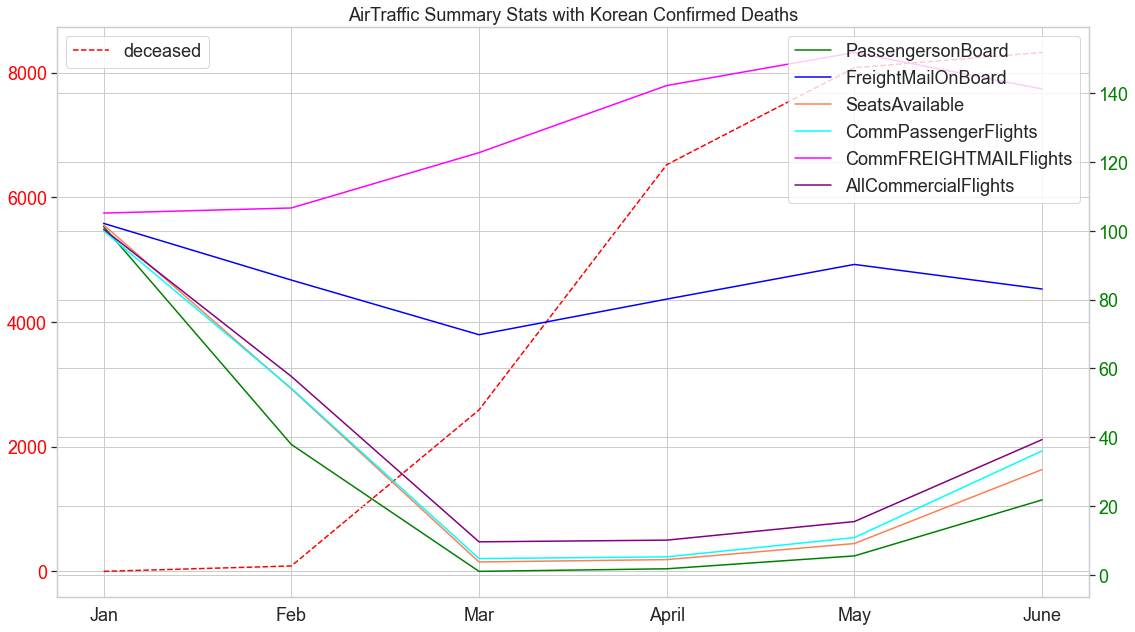

In [271]:
fig, ax = plt.subplots()


# Plot linear sequence, and set tick labels to the same color
ax.plot(mergeddf[['deceased']],'--', color='red',label='deceased')
ax.tick_params(axis='y', labelcolor='red')
ax.legend(loc=2)
# Generate a new Axes instance, on the twin-X axes (same position)
ax2 = ax.twinx()

# Plot exponential sequence, set scale to logarithmic and change tick color
ax2.plot(mergeddf[['PassengersonBoard']], color='green',label='PassengersonBoard')
ax2.plot(mergeddf[['FreightMailOnBoard']], color='blue',label='FreightMailOnBoard')
ax2.plot(mergeddf[['SeatsAvailable']], color='coral',label='SeatsAvailable')
ax2.plot(mergeddf[['CommPassengerFlights']], color='cyan',label='CommPassengerFlights')
ax2.plot(mergeddf[['CommFREIGHTMAILFlights']], color='magenta',label='CommFREIGHTMAILFlights')
ax2.plot(mergeddf[['AllCommercialFlights']], color='purple',label='AllCommercialFlights')

ax2.legend(loc=1)
ax2.tick_params(axis='y', labelcolor='green')
fig.set_size_inches(18.5, 10.5)

SMALL_SIZE = 22
MEDIUM_SIZE = 22
BIGGER_SIZE = 22

plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.title('AirTraffic Summary Stats with Korean Confirmed Deaths')
plt.savefig('DeathsVsCases.png')